<a href="https://colab.research.google.com/github/teodoragrubor/projekatPPPO/blob/master/mozdakonacno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install segmentation_models_pytorch albumentations
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 245kB 41.2MB/s 
     |████████████████████████████████| 634kB 41.1MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=77756e56094f7d5ca3ac9b13499c4805c9b836a3b94ee1b511dfcc199c1ab308
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=29429e3dddf20db2f32b891d85873a575ed6e28460764a2e00e0b616150d4913
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=b9726b8bad2ec1ba56179bb55d4cfc124f998df0600e90f9bea215d6693b5af7
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c

In [ ]:
import os 
import csv 
import re #importovanje regularnog izraza, omogućava stvari poput modifikatora, identifikatora i praznih znakova
import numpy as np 
import pandas as pd #pajtonovi alati za analizu podataka
import matplotlib.pyplot as plt  
import itertools #koristi se za iteraciju struktura podataka 

import cv2
from tqdm.notebook import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

import shutil

import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import albumentations
import torchvision 
from torchvision import transforms, models

import random

import segmentation_models_pytorch as smp
from PIL import Image

In [ ]:
ruta = "/content/drive/MyDrive/#8"
trainpath = "/content/drive/MyDrive/#8/train" 
testpath = "/content/drive/MyDrive/#8/test"

masks = [os.path.join(trainpath,i) for i in os.listdir(trainpath) if "mask" in i]
#listdir - vraca listu koja sadrzi u sebi "mask" iz putanje trainpath
imgs = [i.replace("_mask","") for i in masks]

df = pd.DataFrame({"image":imgs,"mask":masks})
#dvodimenzonalni prikaz podataka u redove i kolone (proveri ovo)

df_train, df_val = train_test_split(df,test_size = 0.15)
#ovo sluzi za podelu podataka u dva podskupa 15%


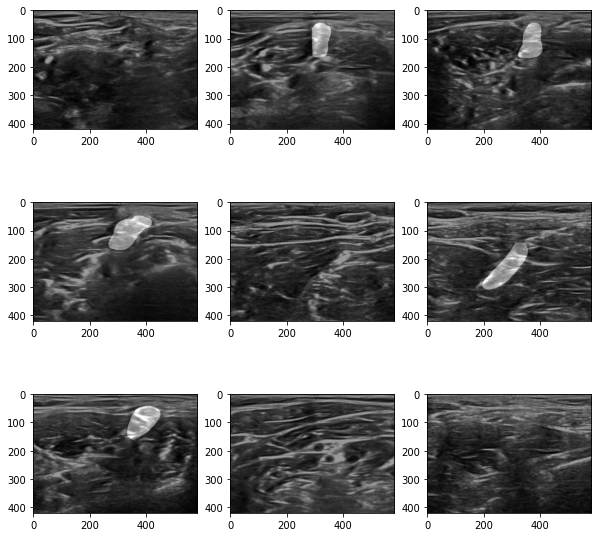

In [ ]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1): #for petlja u programiranju
    ii = random.randint(0, len(df)) 
    img_path=df['image'][ii]
    msk_path=df['mask'][ii]
    plt.imshow(np.array(Image.open(img_path)), cmap = 'gray') 
    plt.imshow(np.array(Image.open(msk_path)),alpha=0.4, cmap = 'gray') #smut je alpha
plt.show()  

In [ ]:
def rle_encoding(x):
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def convert_to_tensor(x,**kwargs):
    return x.transpose(2,0,1).astype("float32")

def func_for_preprocessing(preprocessing_fn=None):
    transform = []
    if preprocessing_fn:
        transform.append(albumentations.Lambda(image=preprocessing_fn))
    transform.append(albumentations.Lambda(image=convert_to_tensor))
    return albumentations.Compose(transform)

def trainaugs():
    transform =  [
                albumentations.Resize(height=224,width=224,interpolation=Image.BILINEAR),
                albumentations.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0),
                albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                albumentations.HorizontalFlip(),
            ]
    return albumentations.Compose(transform)

def valaugs():
    transform = [
                albumentations.Resize(height=224,width=224,interpolation=Image.BILINEAR),
            ]
    return albumentations.Compose(transform)

#pravimo klasu sa dataset
class GetDataset(Dataset):
    def __init__(self,imagespath,maskspath,augment=None,preprocess=None):
        self.imagespath = imagespath
        self.maskspath = maskspath
        self.augment = augment
        self.preprocess = preprocess
        
    def __len__(self):
        return len(self.imagespath)
    
    def __getitem__(self,idx):
        image = cv2.cvtColor(cv2.imread(self.imagespath[idx]),cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskspath[idx], cv2.IMREAD_GRAYSCALE)

        if self.augment:
            sample = self.augment(image=image, mask=mask)
            image,mask = sample['image'],sample['mask']
        if self.preprocess:
            sample = self.preprocess(image=image,mask=mask)
            image,mask = sample['image'],sample['mask']

        mask = (mask / 255).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)

        return image,mask

In [ ]:
encoder = "resnet34"
encoder_wts = "imagenet"
activation = "sigmoid"


model = smp.Unet(encoder_name=encoder,activation=activation,encoder_weights=encoder_wts)
preprocess_func = smp.encoders.get_preprocessing_fn(encoder,encoder_wts)


traindata = GetDataset(imagespath = df_train['image'].tolist(),
                            maskspath = df_train['mask'].tolist(),
                            augment = trainaugs(),
                            preprocess = func_for_preprocessing(preprocess_func))

validationdata = GetDataset(imagespath = df_val['image'].tolist(),
                            maskspath = df_val['mask'].tolist(),
                            augment = valaugs(),
                           preprocess = func_for_preprocessing(preprocess_func))

batch_size = 6
trainloader = DataLoader(traindata,batch_size = batch_size,shuffle=True)
valloader = DataLoader(validationdata,batch_size=batch_size,shuffle=False)

In [ ]:
trainmodel = True
epochs = 2
device = "cuda"
loss = smp.utils.losses.DiceLoss()
metrics = [ smp.utils.metrics.IoU(threshold=0.5) ]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

trainepoch = smp.utils.train.TrainEpoch(model,loss=loss,optimizer=optimizer,metrics=metrics,device=device,verbose=True)
validepoch = smp.utils.train.ValidEpoch(model,loss=loss,metrics=metrics,device=device,verbose=True)